In [96]:
import assembly as assembly
import time as time
import numpy as np
import matplotlib.pyplot as plt
import os
import functools
import pandas as pd
from imports import *  # shortcut for standard imports

%matplotlib inline

In [97]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [98]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [127]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'

#session = '008229_hippoSIT_2022-05-17_21-44-43'
#session = '008229_hippoSIT_2022-05-16_20-36-44'
#session = '008229_hippoSIT_2022-05-20_15-54-39'
session = '008229_hippoSIT_2022-05-18_14-36-18'
unit_name = '8-18'

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    s_times= np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
    i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
    
speed = tl[:, 3]

In [128]:
filtered = butter_highpass_filter(i_rate, 0.05, 100)

In [48]:
# # normalize to the mean rate with a sliding window
width = 50000  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

i_rate_lf = np.convolve(i_rate, kernel, 'same') / kernel.sum()
i_rate_lf[:int(width/2)]  = i_rate_lf[int(width/2) + 1]
i_rate_lf[-int(width/2):] = i_rate_lf[-int(width/2) - 1]

(0.0, 2400.0)

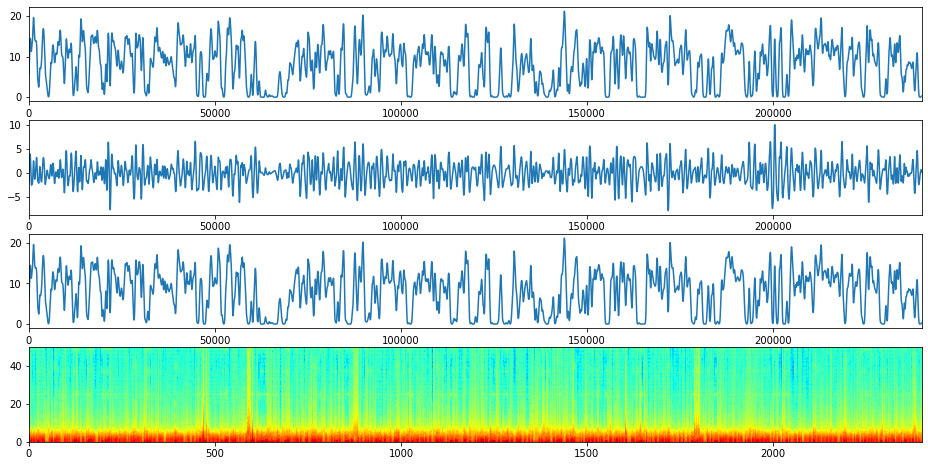

In [129]:
fig = plt.figure(figsize=(16, 8))

t_l, t_r = 0, 2400  # seconds

ax = fig.add_subplot(4, 1, 1)
ax.plot(i_rate)
ax.set_xlim(t_l*s_rate, t_r*s_rate)

ax = fig.add_subplot(4, 1, 2)
ax.plot(filtered)
ax.set_xlim(t_l*s_rate, t_r*s_rate)

ax = fig.add_subplot(4, 1, 3)
#ax.plot(i_rate/i_rate_lf)
ax.plot(i_rate)
ax.set_xlim(t_l*s_rate, t_r*s_rate)

ax = fig.add_subplot(4, 1, 4)
#_ = ax.specgram(i_rate/i_rate_lf, Fs=100, cmap='jet')
_ = ax.specgram(speed, Fs=100, cmap='jet')
ax.set_xlim(t_l, t_r)

(array([41909., 13938., 12331., 12175., 14046., 20284., 23176., 30340.,
        23540., 20378., 13961.,  8342.,  3585.,  1544.,   452.]),
 array([ 0.        ,  1.41011068,  2.82022135,  4.23033203,  5.6404427 ,
         7.05055338,  8.46066406,  9.87077473, 11.28088541, 12.69099608,
        14.10110676, 15.51121743, 16.92132811, 18.33143879, 19.74154946,
        21.15166014]),
 <BarContainer object of 15 artists>)

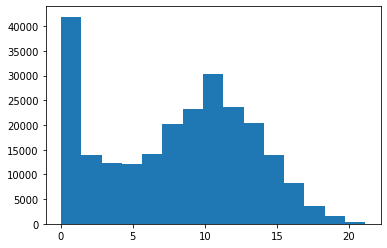

In [130]:
plt.hist(i_rate, bins=15)

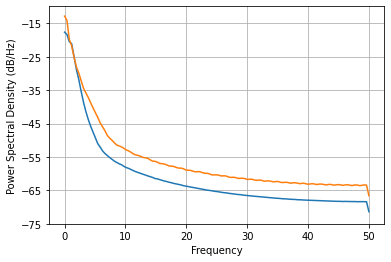

In [131]:
idxs_active  = np.where(i_rate > 5)[0]
idxs_passive = np.where(i_rate < 5)[0]

_ = plt.psd(speed[idxs_active], Fs=100)
_ = plt.psd(speed[idxs_passive], Fs=100)